# Quickstart 1: Microscopy Basic

**Learning Objectives**:
- Understand preset loading
- See auto-computed physics parameters
- Visualize resolution limit
- Basic instrument usage

**Estimated Runtime**: 15-20 minutes

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from prism.config.constants import um
from prism.core import create_usaf_target
from prism.core.instruments import create_instrument
from prism.scenarios import get_scenario_preset

## 1. Load Microscope Preset

We'll use the `microscope_40x_air` preset, which represents:
- 40x magnification
- 0.9 NA (Numerical Aperture)
- Air immersion medium (n=1.0)
- Brightfield illumination

In [2]:
# Load preset scenario
scenario = get_scenario_preset("microscope_40x_air")

print("Microscope Scenario Configuration:")
print(f"  Name: {scenario.name}")
print(f"  Objective: {scenario.objective_spec}")
print(f"  Illumination Mode: {scenario.illumination_mode}")
print(f"  Wavelength: {scenario.wavelength * 1e9:.0f} nm")
print(f"  Lateral Resolution: {scenario.lateral_resolution_nm:.0f} nm")
print(f"  Axial Resolution: {scenario.axial_resolution_um:.2f} µm")
print(f"  Field of View: {scenario.field_of_view_um:.1f} µm")

Microscope Scenario Configuration:
  Name: Microscope 40x_0.9NA_air (brightfield)
  Objective: 40x_0.9NA_air
  Illumination Mode: brightfield
  Wavelength: 550 nm
  Lateral Resolution: 373 nm
  Axial Resolution: 1.36 µm
  Field of View: 88.3 µm


## 2. Create Microscope Instrument

Convert the scenario to an actual instrument we can use for imaging.

In [3]:
# Convert scenario to instrument configuration
instrument_config = scenario.to_instrument_config()

# Create the actual microscope instrument
microscope = create_instrument(instrument_config)

print("\nMicroscope Instrument:")
print(f"  Type: {type(microscope).__name__}")
print(f"  Resolution Limit: {microscope.resolution_limit * 1e9:.0f} nm")
info = microscope.get_info()
print(f"  Object Pixel Size: {info['object_pixel_size'] * 1e9:.1f} nm")


Microscope Instrument:
  Type: Microscope
  Resolution Limit: 373 nm
  Object Pixel Size: 86.2 nm


## 3. Auto-Computed Physics Parameters

The microscope preset automatically computes key optical parameters:

**Lateral Resolution (Abbe Limit)**:
$$\Delta x = \frac{0.61\lambda}{\text{NA}}$$

**Axial Resolution**:
$$\Delta z = \frac{2n\lambda}{\text{NA}^2}$$

In [4]:
# Get optical parameters from scenario
wavelength = scenario.wavelength
NA = scenario._obj.numerical_aperture
n = scenario._obj.medium_index

# Verify computed resolution limits
lateral_resolution = 0.61 * wavelength / NA
axial_resolution = 2 * n * wavelength / (NA**2)

print("\nResolution Limits (Computed):")
print(f"  Lateral (Abbe): {lateral_resolution * 1e9:.0f} nm")
print(f"  Axial: {axial_resolution * 1e6:.2f} µm")
print("\n  From Scenario:")
print(f"  Lateral: {scenario.lateral_resolution_nm:.0f} nm")
print(f"  Axial: {scenario.axial_resolution_um:.2f} µm")


Resolution Limits (Computed):
  Lateral (Abbe): 373 nm
  Axial: 1.36 µm

  From Scenario:
  Lateral: 373 nm
  Axial: 1.36 µm


## 4. Create Test Pattern

We'll use a USAF-1951 resolution test target to demonstrate the microscope's resolving power.

**Important**: The target is created with proper margins (25% on each side) to allow for
correct diffraction simulation and avoid periodic boundary artifacts.

In [5]:
# Create USAF-1951 target with physical field size
# Important: Target resolution must match the instrument's grid size
# IMPORTANT: Match target FOV to microscope scenario FOV
# Mismatch causes FFT wraparound artifacts ("plaid" pattern)
field_size = scenario.field_of_view_um * um  # Match microscope FOV exactly
resolution = scenario.n_pixels  # Match instrument grid size (default 1024)

# Create target with automatic group selection based on field size
target = create_usaf_target(
    field_size=field_size,
    resolution=resolution,
    groups=None,  # (4, 5, 6, 7),  # High-resolution groups for microscopy
    margin_ratio=0.25,  # 25% margin on each side for proper diffraction
)

# Generate target pattern
ground_truth = target.generate()

print("\nTarget Properties:")
print(f"  Field size: {field_size * 1e6:.0f} µm")
print(f"  Resolution: {resolution} × {resolution} pixels")
print(f"  Pixel size: {target.config.pixel_size * 1e9:.1f} nm")
print(f"  Active region: {target.config.active_size} × {target.config.active_size} pixels")
print(f"  Margin: {target.config.margin_pixels} pixels per side")


Target Properties:
  Field size: 88 µm
  Resolution: 1024 × 1024 pixels
  Pixel size: 86.2 nm
  Active region: 512 × 512 pixels
  Margin: 256 pixels per side


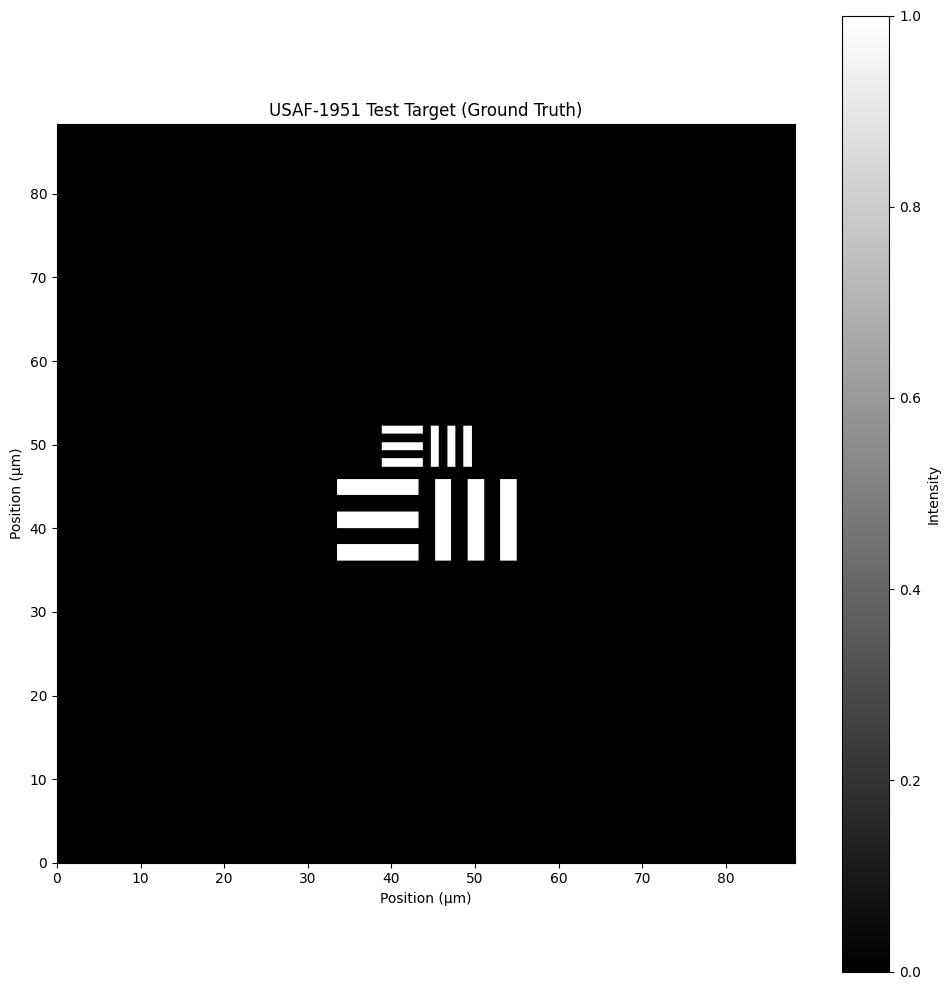

In [6]:
# Visualize
plt.figure(figsize=(10, 10))
extent = [0, field_size * 1e6, 0, field_size * 1e6]  # µm
plt.imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
plt.title("USAF-1951 Test Target (Ground Truth)")
plt.xlabel("Position (µm)")
plt.ylabel("Position (µm)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

## 5. Simulate Microscope Measurement

We'll use the microscope to image the test target and see how the optical system's resolution limit affects the measurement.

## Important: Input Field Preparation

For physically correct wave optics simulation:

1. **FOV Matching**: Target `field_size` must match `scenario.field_of_view_um`
   - Mismatch causes FFT wraparound ("plaid" artifacts)

2. **Intensity vs Amplitude**:
   - Targets generate **intensity** (transmission, 0-1)
   - Wave optics needs **amplitude** = sqrt(intensity)
   - Convert: `amplitude = torch.sqrt(intensity).to(torch.complex64)`

3. **Batch Dimensions**: Forward model expects (B, C, H, W) shape
   - Use `.unsqueeze(0).unsqueeze(0)` to add batch and channel dims

2025-11-28 01:14:25 | INFO     | Forward model regime: simplified (manual override)


2025-11-28 01:14:25 | INFO     | ============================================================


2025-11-28 01:14:25 | INFO     | Microscope Forward Model Configuration


2025-11-28 01:14:25 | INFO     | ============================================================


2025-11-28 01:14:25 | INFO     |   Objective focal length: 5.00 mm


2025-11-28 01:14:25 | INFO     |   Tube lens focal length: 200.00 mm


2025-11-28 01:14:25 | INFO     |   Working distance: 5.000 mm


2025-11-28 01:14:25 | INFO     |   Numerical aperture: 0.9


2025-11-28 01:14:25 | INFO     |   Medium index: 1.0


2025-11-28 01:14:25 | INFO     |   Defocus parameter δ: 0.000000


2025-11-28 01:14:25 | INFO     |   Selected regime: simplified


2025-11-28 01:14:25 | INFO     | ============================================================


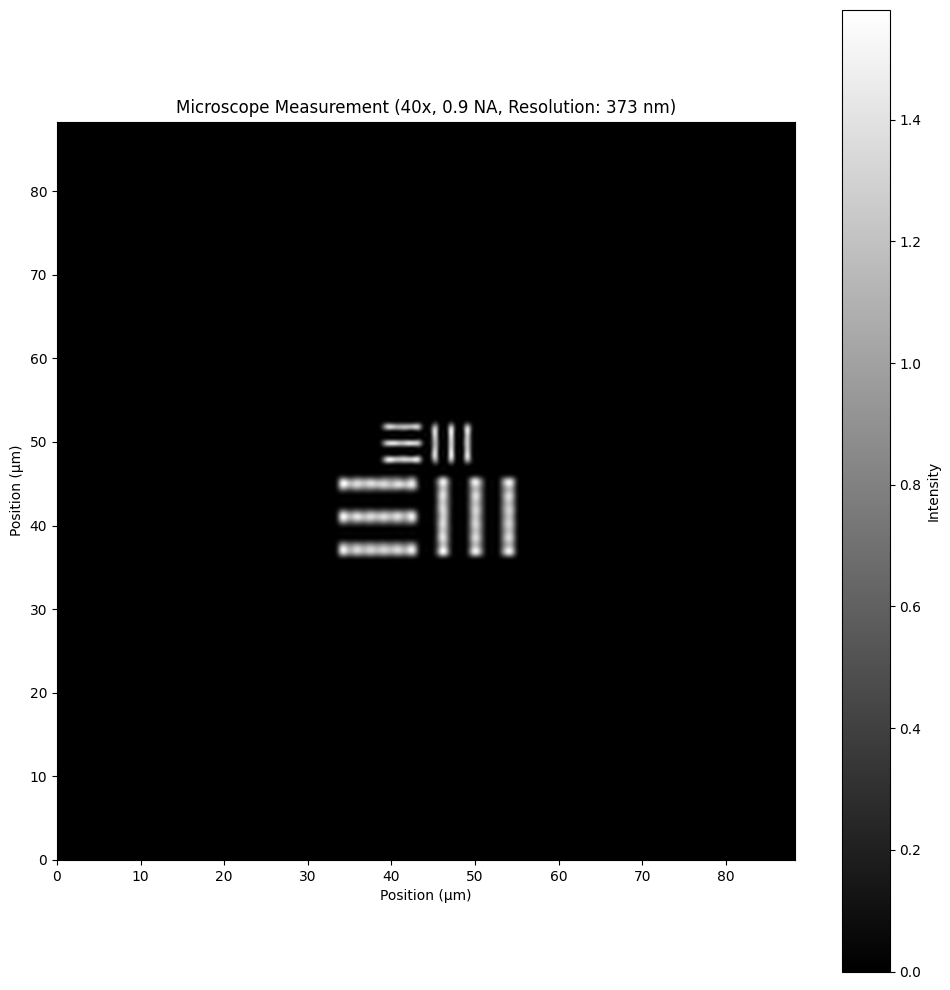

In [7]:
# Simulate measurement using the new API
# input_mode='intensity' automatically converts transmission to amplitude via sqrt()
input_field = ground_truth.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    measurement = microscope.forward(
        input_field,
        input_mode="intensity",  # Auto-converts via sqrt()
        input_pixel_size=target.config.pixel_size,  # Enables FOV validation
    )

# Remove batch and channel dimensions
measurement_2d = measurement.squeeze().cpu().numpy()

# Visualize measurement
plt.figure(figsize=(10, 10))
plt.imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
plt.title(f"Microscope Measurement (40x, 0.9 NA, Resolution: {lateral_resolution * 1e9:.0f} nm)")
plt.xlabel("Position (µm)")
plt.ylabel("Position (µm)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

## 6. Compare Ground Truth vs Measurement

Let's compare the original target with the microscope measurement to visualize the effect of the resolution limit.

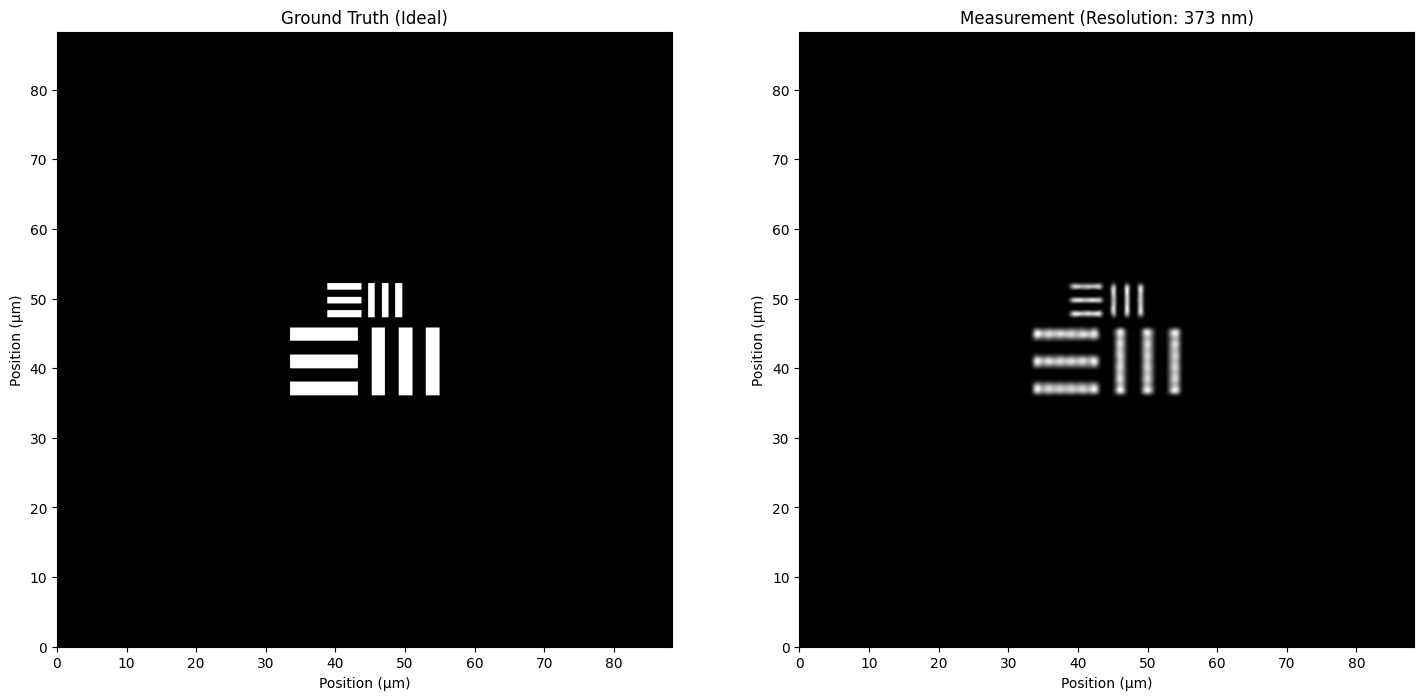


Observations:
  - Finer features (smaller line pairs) become blurred
  - Features smaller than ~373 nm cannot be resolved
  - This demonstrates the fundamental optical resolution limit
  - Note the zero-margin region preserved around the active pattern


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Ground truth
axes[0].imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
axes[0].set_title("Ground Truth (Ideal)")
axes[0].set_xlabel("Position (µm)")
axes[0].set_ylabel("Position (µm)")

# Measurement
axes[1].imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
axes[1].set_title(f"Measurement (Resolution: {lateral_resolution * 1e9:.0f} nm)")
axes[1].set_xlabel("Position (µm)")
axes[1].set_ylabel("Position (µm)")

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - Finer features (smaller line pairs) become blurred")
print(f"  - Features smaller than ~{lateral_resolution * 1e9:.0f} nm cannot be resolved")
print("  - This demonstrates the fundamental optical resolution limit")
print("  - Note the zero-margin region preserved around the active pattern")

## 7. Visualize Point Spread Function (PSF)

The PSF describes how a point source is imaged by the optical system. Its width determines the resolution limit.

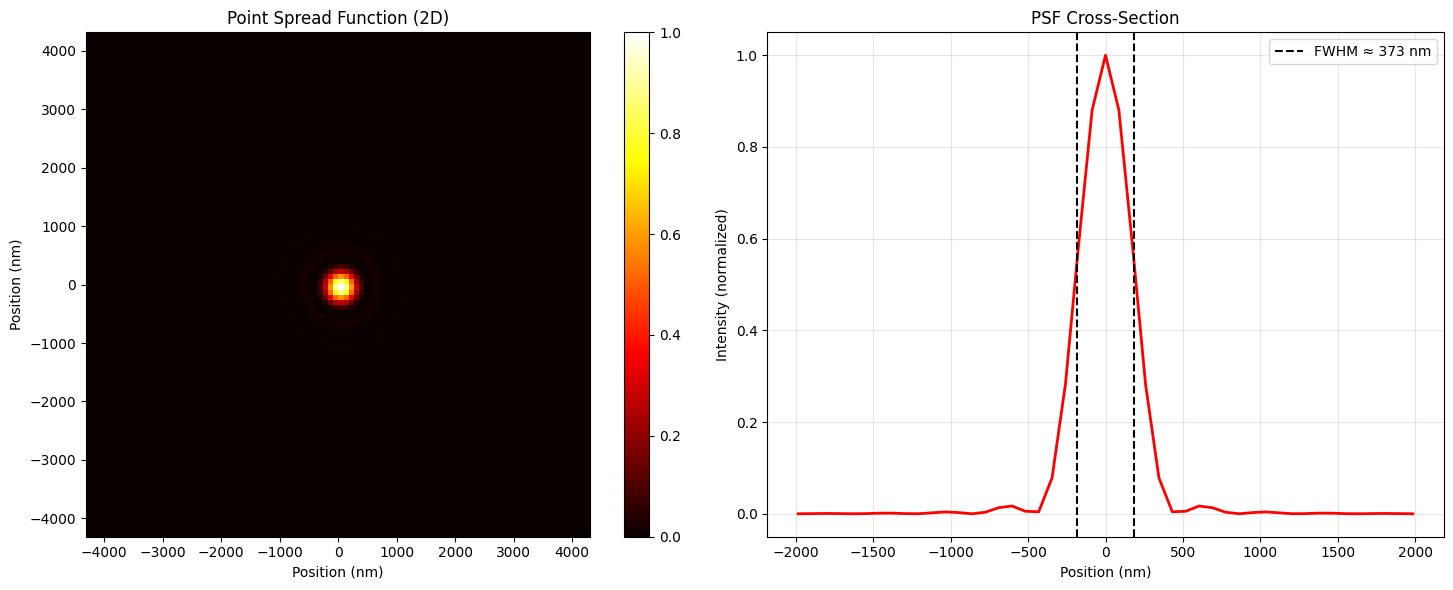


PSF Width (FWHM): ~373 nm
This width determines the smallest features that can be resolved.


In [9]:
# Compute PSF using the microscope
psf = microscope.compute_psf(illumination_mode="brightfield")

# PSF is in frequency space, need to shift to center
psf_centered = torch.fft.fftshift(psf).cpu().numpy()

# Get pixel scale in object space
object_pixel_size = info["object_pixel_size"]
fov = object_pixel_size * psf_centered.shape[0]

# Visualize PSF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 2D PSF
center = psf_centered.shape[0] // 2
crop = 50  # Show central region
psf_crop = psf_centered[center - crop : center + crop, center - crop : center + crop]
crop_extent = crop * object_pixel_size * 1e9  # nm

im = axes[0].imshow(
    psf_crop, cmap="hot", extent=[-crop_extent, crop_extent, -crop_extent, crop_extent]
)
axes[0].set_title("Point Spread Function (2D)")
axes[0].set_xlabel("Position (nm)")
axes[0].set_ylabel("Position (nm)")
plt.colorbar(im, ax=axes[0])

# Cross-section
x_coords = (np.arange(psf_centered.shape[0]) - center) * object_pixel_size * 1e9  # nm
psf_line = psf_centered[center, :]

# Zoom to central region
mask = np.abs(x_coords) < 2000  # Show ±2000 nm
axes[1].plot(x_coords[mask], psf_line[mask], "r-", linewidth=2)
axes[1].axvline(
    lateral_resolution * 1e9 / 2,
    color="k",
    linestyle="--",
    label=f"FWHM ≈ {lateral_resolution * 1e9:.0f} nm",
)
axes[1].axvline(-lateral_resolution * 1e9 / 2, color="k", linestyle="--")
axes[1].set_title("PSF Cross-Section")
axes[1].set_xlabel("Position (nm)")
axes[1].set_ylabel("Intensity (normalized)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPSF Width (FWHM): ~{lateral_resolution * 1e9:.0f} nm")
print("This width determines the smallest features that can be resolved.")

## Summary

In this notebook, we:
1. ✅ Loaded a microscope preset (`microscope_40x_air`)
2. ✅ Created a microscope instrument from the scenario
3. ✅ Examined auto-computed physics parameters (NA, resolution limits)
4. ✅ Created a USAF-1951 test target with proper margins
5. ✅ Simulated a microscope measurement
6. ✅ Visualized the PSF and resolution limit

**Key Takeaways**:
- Resolution limit for 40x, 0.9 NA at 550nm: **~370 nm**
- Features smaller than this limit cannot be resolved
- The PSF width determines the resolution
- Proper margins are essential for correct diffraction simulation
- SPIDS automatically handles all the physics!

**Next Steps**:
- Try different presets (e.g., `microscope_100x_oil` for higher resolution)
- Experiment with different wavelengths
- See [Quickstart 2: Drone Basic](quickstart_02_drone_basic.ipynb) for aerial imaging